# Time series analysis with ARIMA
We are going to predict the number of internation airline passengers using ARIMA

## Import libraries and get sample data

In [6]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

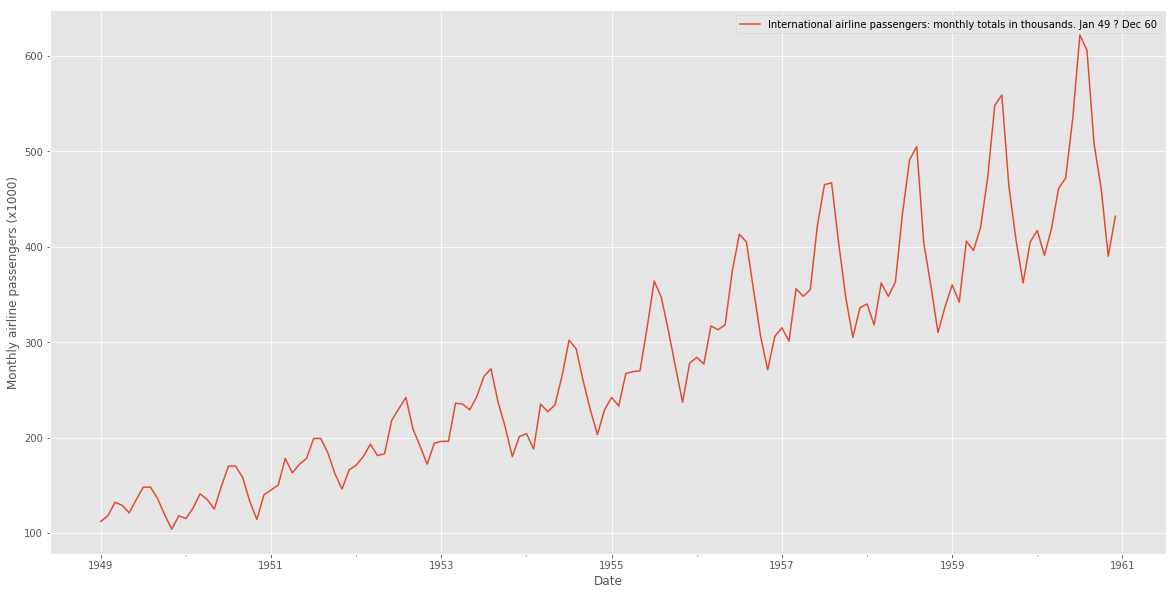

In [7]:
# Load the data
ts = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
ts['Month']=pd.to_datetime(ts['Month'], format='%Y-%m-%d')
ts.set_index(['Month'], inplace=True)

# Plot the data
ts.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

Stationarity is defined using a very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

* Constant mean
* Constant variance
* An autocovariance that does not depend on time.

<b>Plotting Rolling Statistics:</b> We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

<b>Dickey-Fuller Test:</b> This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ```Test Statistic``` is less than the ```Critical Value```, we can reject the null hypothesis and say that the series is stationary.

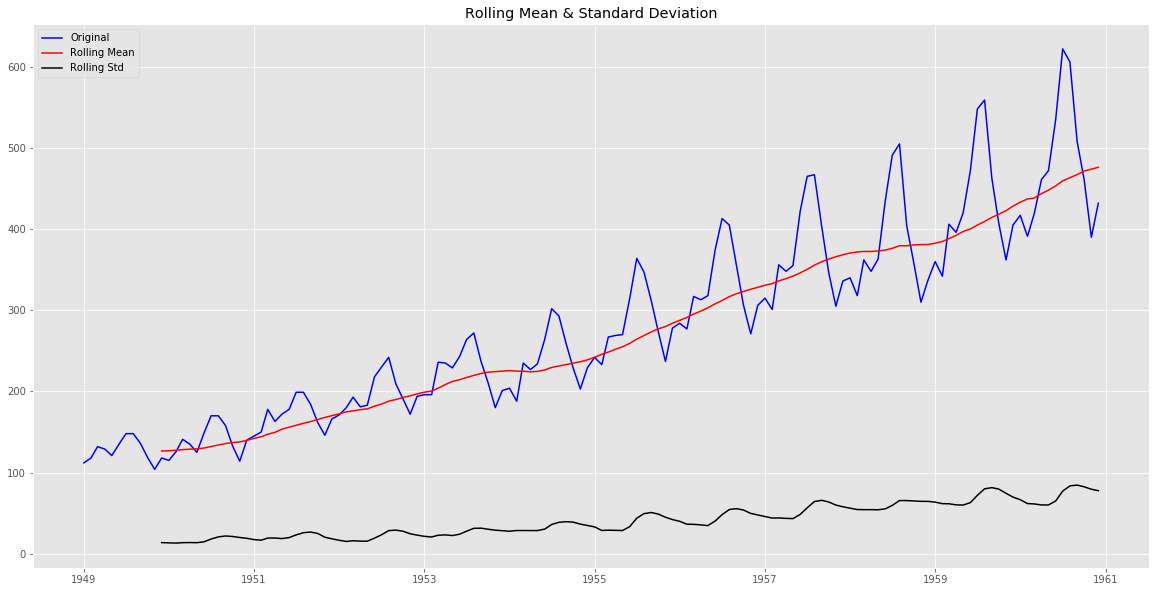

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    ### IMPLEMENT AUGMENTED DICKEY-FULLER TEST
    ### BE CAREFUL WITH THE EXPECTED INPUT DIMENSION OF ADFULLER
    ### WE ARE USING A 1 DIMENSIONAL TIME SERIES
    dftest = adfuller(np.squeeze(timeseries.values), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('Results of Dickey-Fuller Test:')
    print(dfoutput)

test_stationarity(ts)

Its obviously not stationary at the moment. Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationarity of a TS:
1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.


## Eliminating trend 

To eliminate **trend** we will apply a transformation that makes the values more or less same, ie. we use log

One simple way that could eliminate trend is to apply a log transformation to the data:

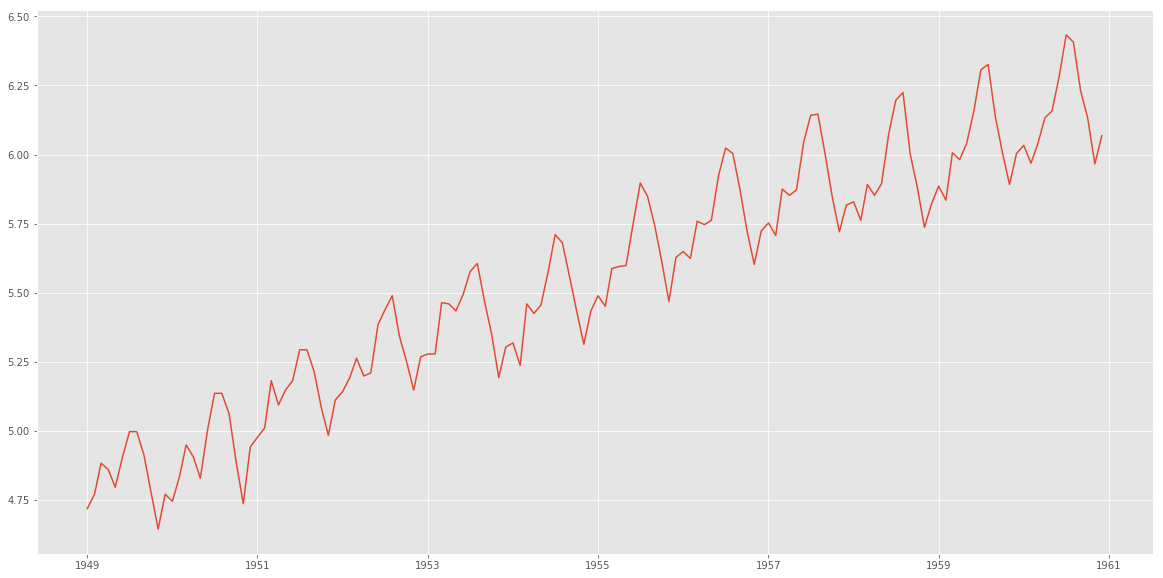

In [9]:
### IMPLEMENT LOG TRANSFORMATION AND PLOT THE DATA
ts_log = np.log(ts)
plt.plot(ts_log)

It's already slightly better but we still have to account for the noise, for this we can use a rolling average:

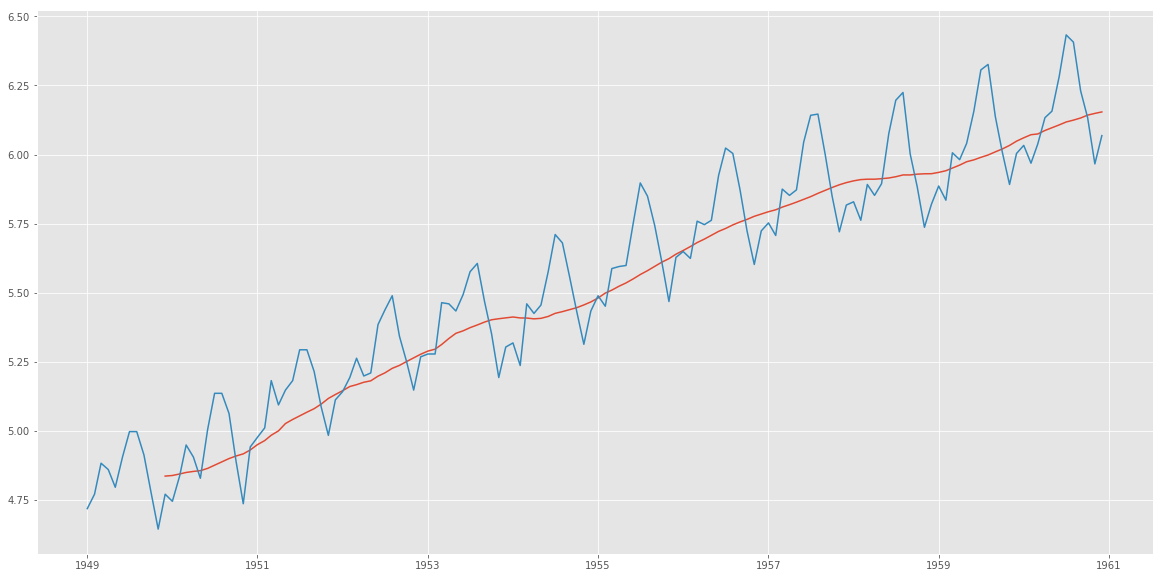

In [10]:
### IMPLEMENT ROLLING AVERAGE AND PLOT BOTH THE ORIGINAL (LOG) DATA AND THE AVERAGED DATA
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth)
plt.plot(ts_log)
plt.show()

There is obviously still a strong trend observable but note that we can make the series stationary now by subtracting the rolling average from the time series:

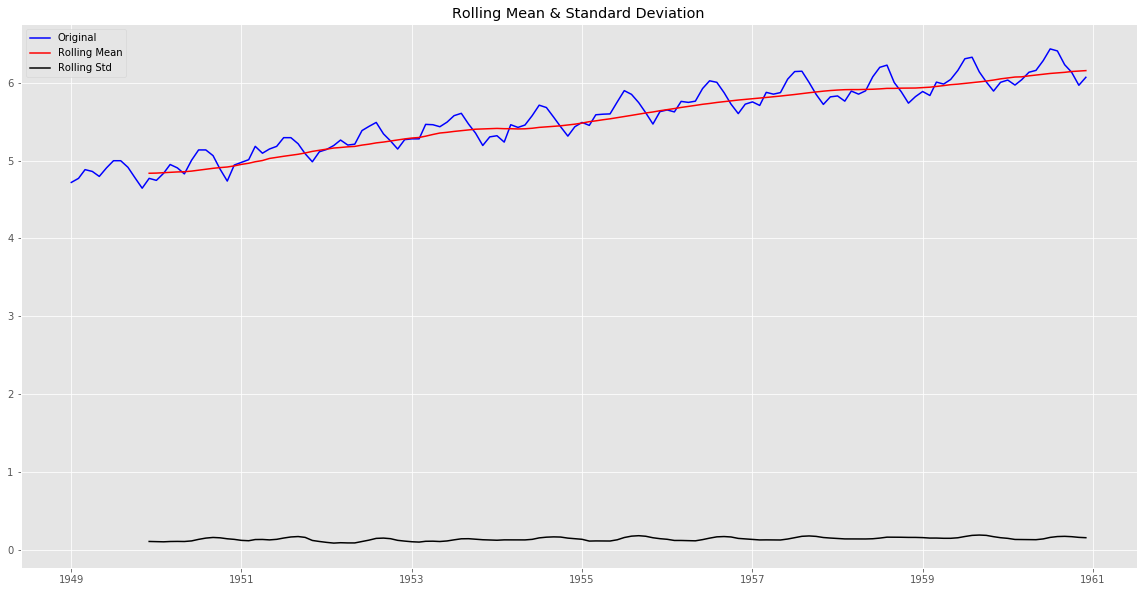

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


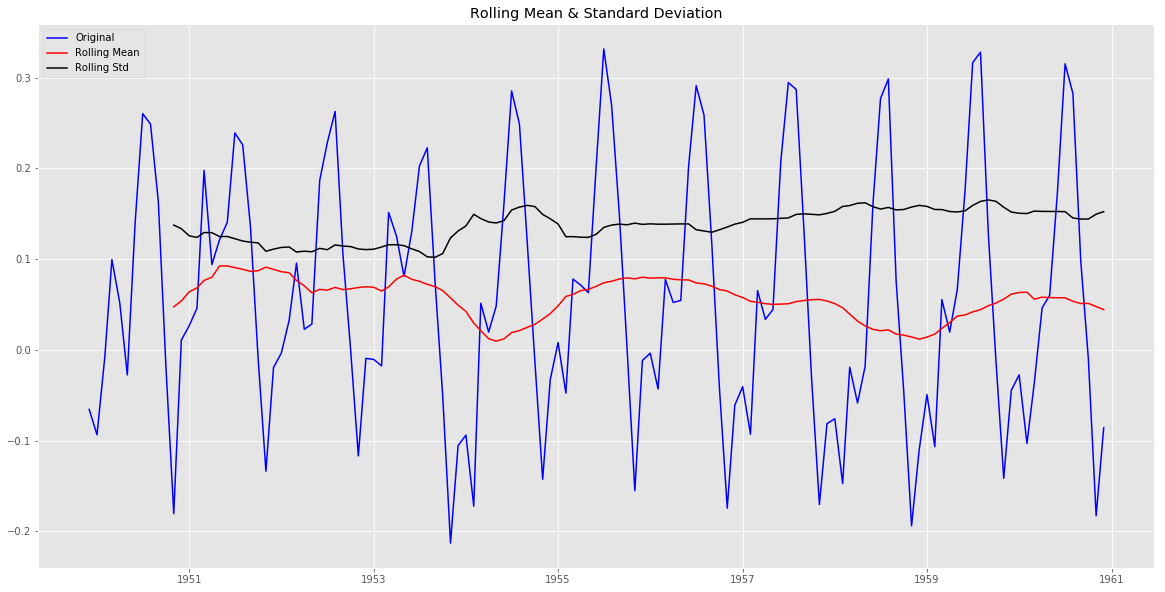

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [12]:
### SUBTRACT THE MEAN TO MAKE THE SYSTEM STATIONARY AND TEST BOTH FOR STATIONARITY
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)

# # Perform Dickey-Fuller on both
test_stationarity(ts_log)
test_stationarity(sub_ts)

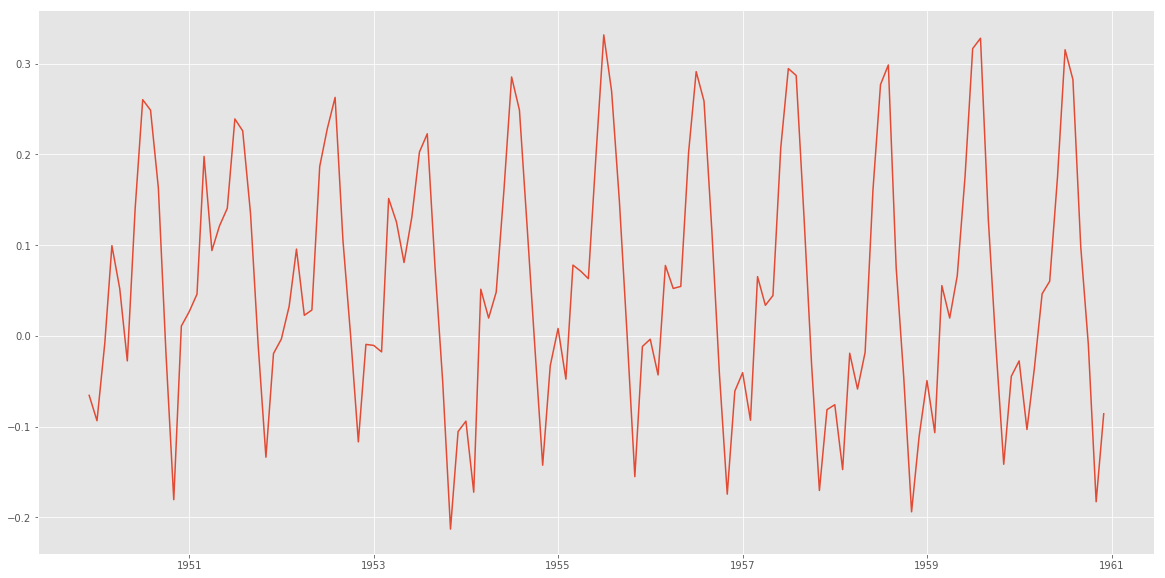

In [13]:
plt.plot(sub_ts)

And voila, our time series are now stationary with a confidence level of > 97.5 percent ! 

Furthermore, since it can be hard to estimate a good rolling window, we took 12 now because of the monthly dependence we can also use an exponential weighted average that is less parameter dependent (you can set halflife=12):

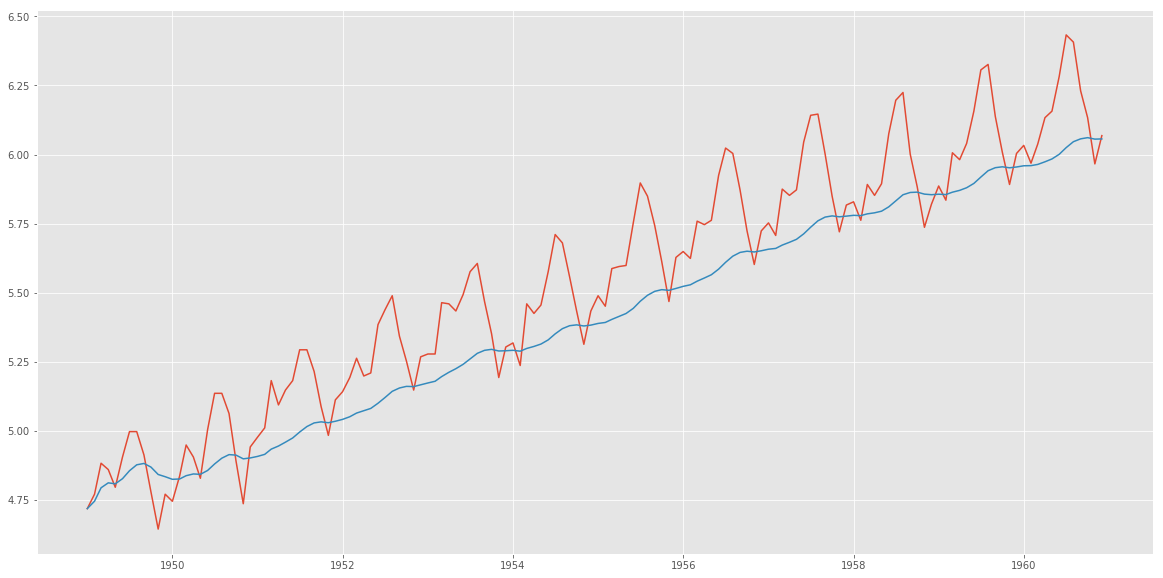

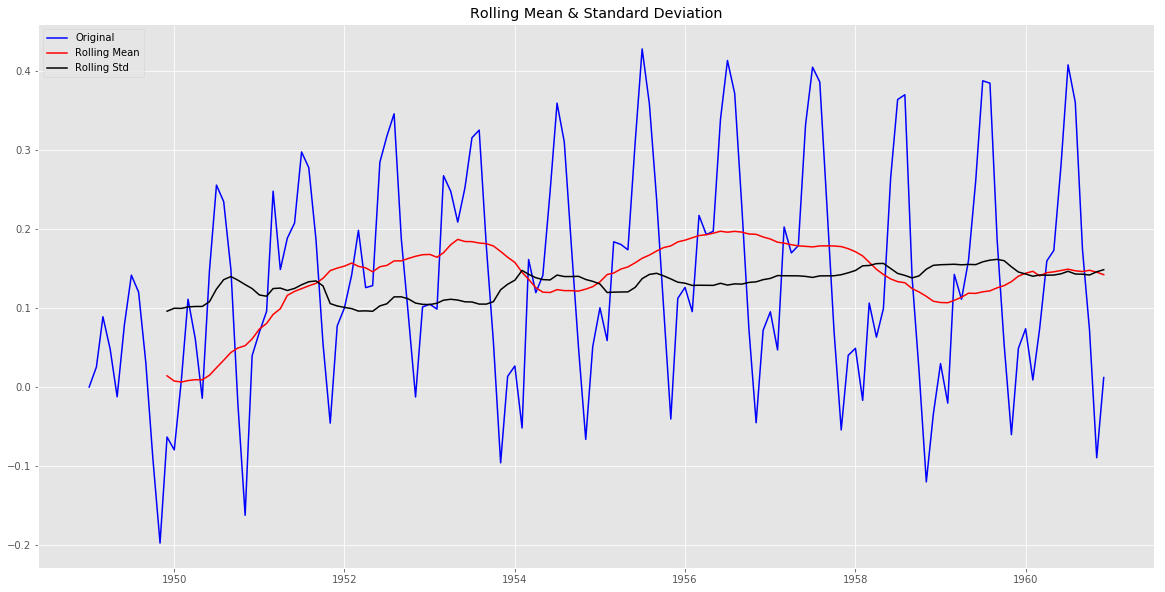

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
### CALCULATE EXPONENTIONAL WEIGHTED MOVING AVERAGE
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg)
plt.show()

exp_ts_diff = ts_log - expwighted_avg
test_stationarity(exp_ts_diff)

Since the test statistic is now lower than 1% critical value, it means that we are 99% sure that we have a stationary series.


## Differencing ##
Another good way to eliminate trend and seasonality is by differencing the input, remember the differencing part of the ARIMA model:

$X'_t = X_t - X_{t-1}$

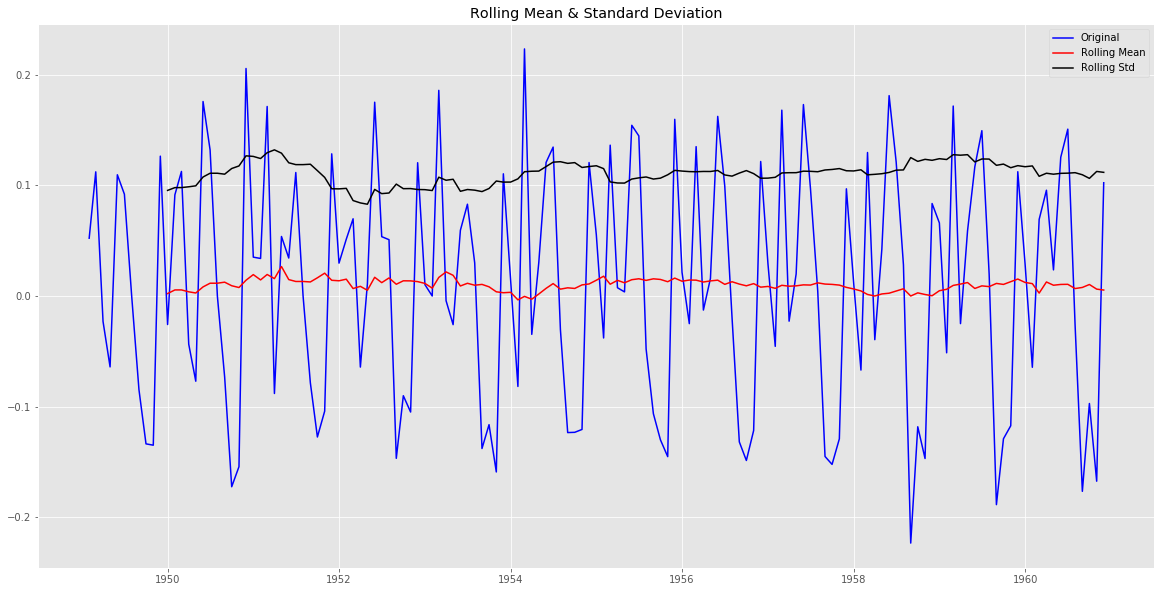

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [11]:
### IMPLEMENT 1D DIFFERENCING HERE AND TEST STATIONARITY
ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff)

Mm, reasonable results but we could do slightly better, let's try differencing twice over the input:

$X'_t = (X_t - X_{t-1}) - (X_{t-1} - X_{t-2})$

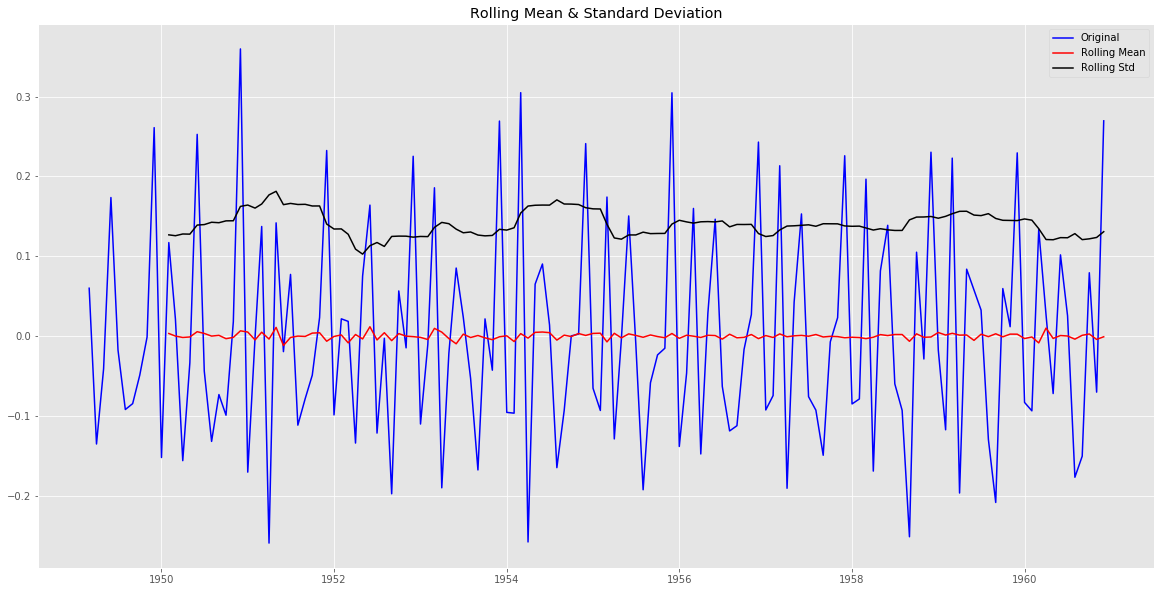

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [12]:
### IMPLEMENT TWO TIMES DIFFERENCING AND TEST FOR STATIONARITY
ts_diff = (ts_log - ts_log.shift()) - (ts_log.shift() - ts_log.shift().shift())
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff)

Pretty huh! This is exactly what the ARIMA model does when d=2, the idea is to remove the non stationarity before fitting a linear model, after which we can add this back to our fitted model when doing predictions.

## Decomposition ##

Next up, we can decompose the time series in a series of factors to extract the characteristics (trend, seasonality and residuals)

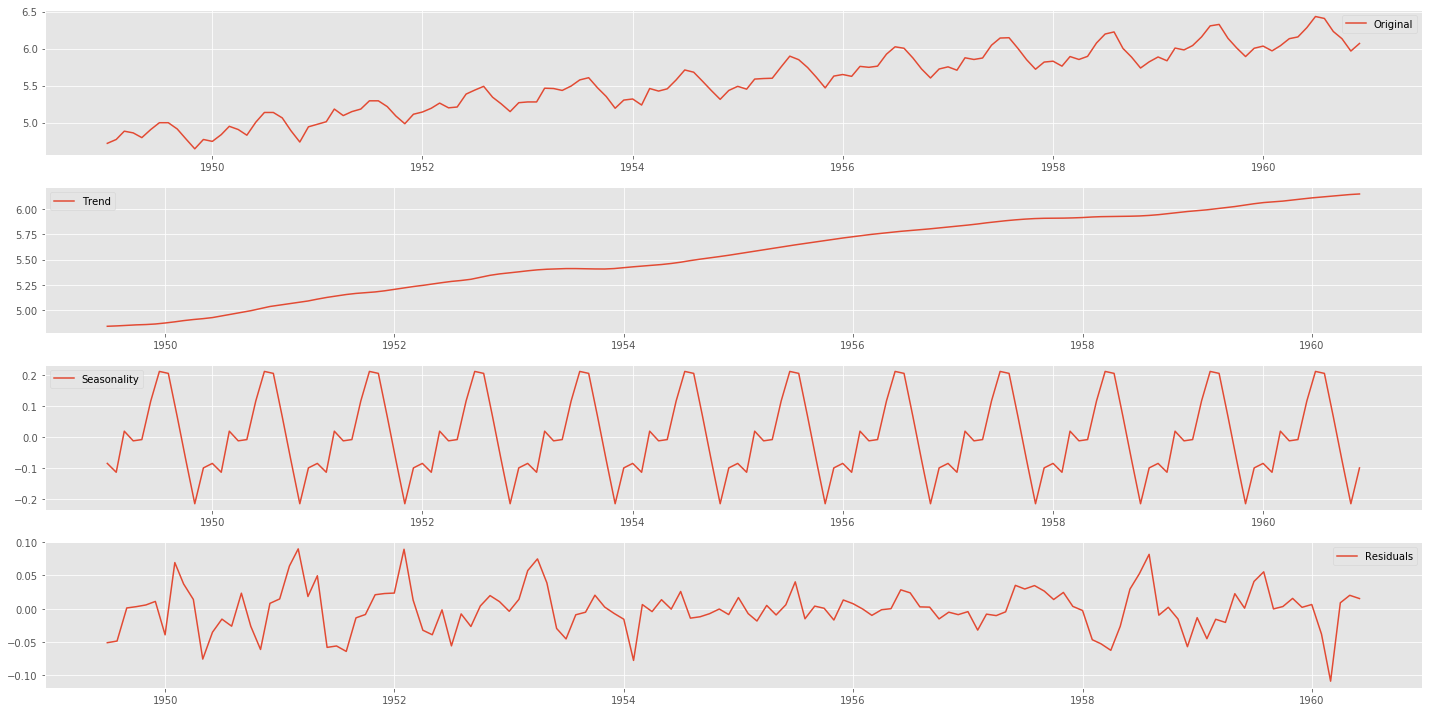

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Implement the decomposition here
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

def plot_decomposition(original, trend, seasonality, residuals):
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
plot_decomposition(ts_log, trend, seasonal, residual)

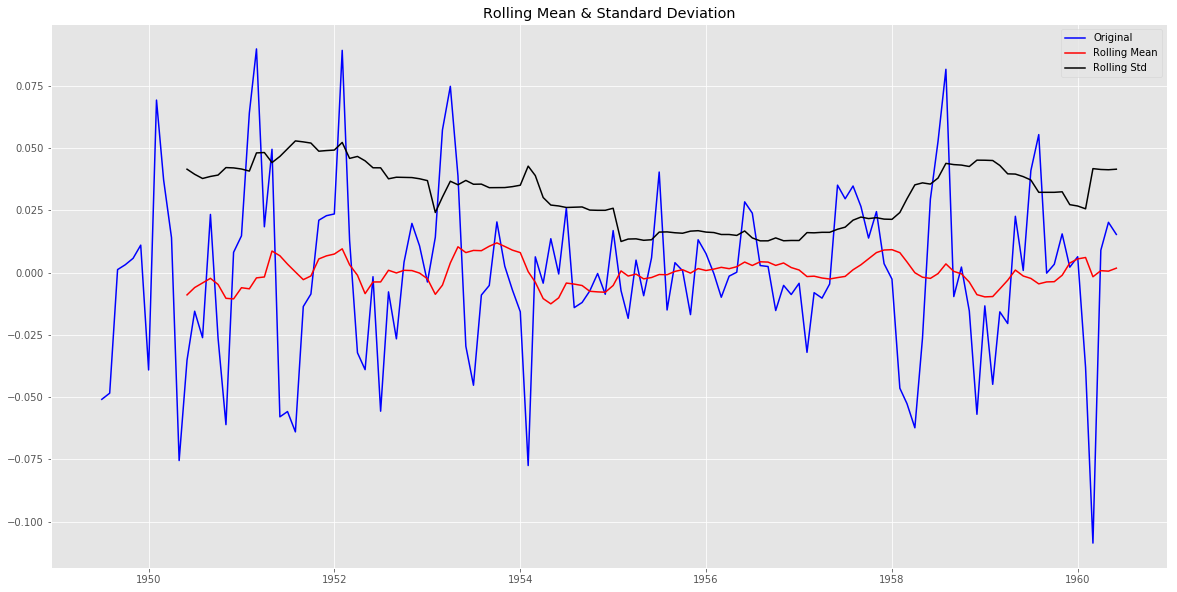

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [14]:
### SHOW THAT THE RESIDUALS FROM THIS METHOD ARE STATIONARY
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

For ease we now use a grid search over all possible combinations of parameter values within a predefined range of values. 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [15]:
# Define parameter range and get cross product
q = d = range(0, 2)
p = range(0, 4)
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of the data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [15]:
train_data = ts['1949-01-01':'1959-12-01']
test_data = ts['1960-01-01':'1960-12-01']

We are now going to fit the model, we will use the SARIMAX model from the statsmodel package:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [17]:
warnings.filterwarnings("ignore")

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        ### FIT THE BEST POSSIBLE MODEL USING A GRID SEARCH BASED ON THE LOWEST AIC VALUE
        ### BE SURE TO SET enforce_stationarity AND enforce_invertibility to false
        mod = sm.tsa.statespace.SARIMAX(train_data,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()

        print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
        AIC.append(results.aic)
        SARIMAX_model.append([param, param_seasonal])

In [18]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.2055109863371 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [16]:
### FIT THE BEST POSSIBLE MODEL
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(3,1,0),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## Results
Now let's create some predictions. We can use the get_prediction() function of the model:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction.html

We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [20]:
### IMPLEMENT IN-SAMPLE PREDICTION WITHOUT DYNAMIC FORECASTING (START 1958-01-01)
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)

2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [21]:
### IMPLEMENT IN-SAMPLE PREDICTION WITH DYNAMIC FORECASTING (START 1958-01-01)
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [22]:
### IMPLEMENT OUT-OF-SAMPLE FORECASTING (END 1962-12-01) (check get_forecast()) 
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()

For out of sample predictions it can be useful to get the confidence interval, such that we have a measure of how sure the model is about a certain prediction:

In [23]:
### IMPLEMENT CONFIDENCE INTERVAL ON GENERATED PREDICTIONS
pred2_ci = pred2.conf_int()

Let's plot all this

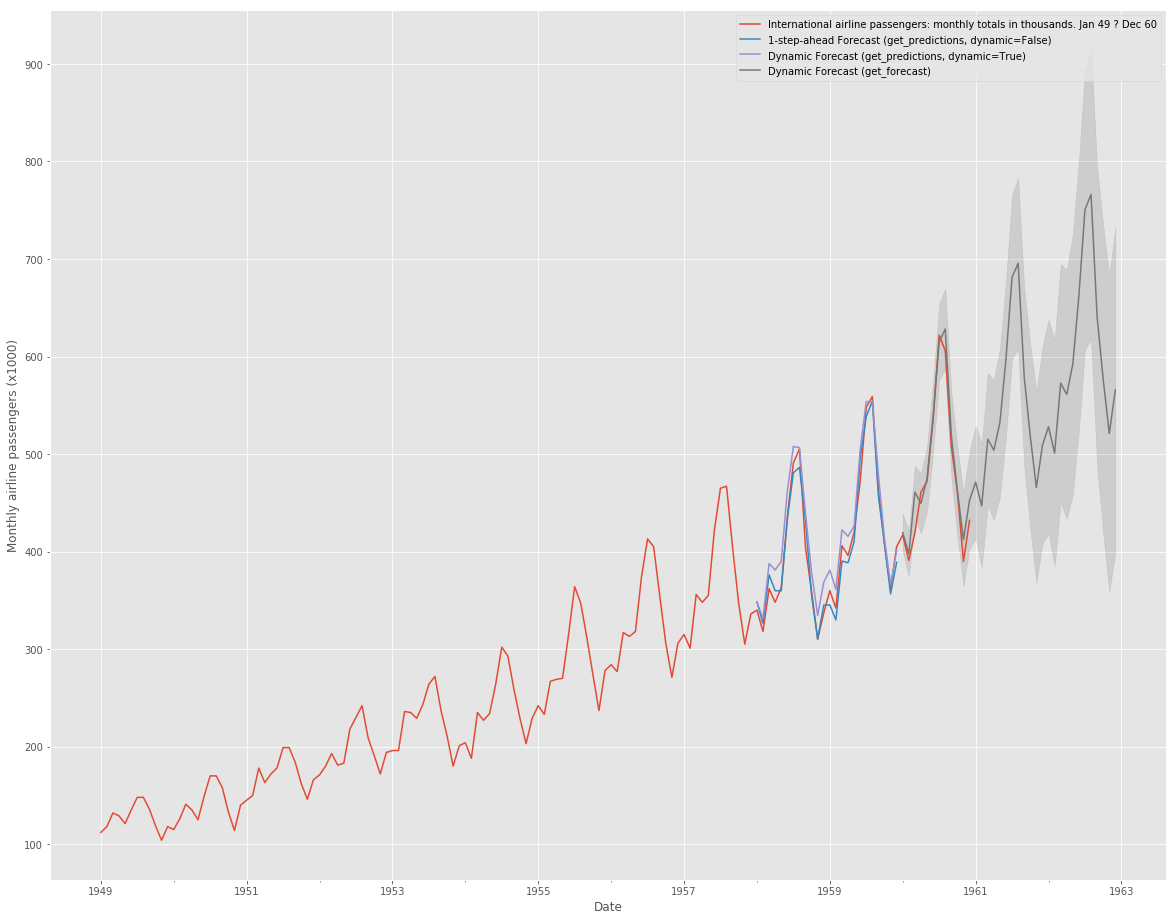

In [24]:
ax = ts.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample prediction. For such a simple time series, the ARIMA model is able to forecast the 1960 values fairly accurately. What else is catching your attention?